## Logistic regression with MNIST

### Libraries

In [1]:
# libraries
using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, categorical
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

using GLM               # (lm works as regression; GLM not OK for categorical outcomes)
using MLJLinearModels   # LogisticClassifier

using LinearAlgebra     # pinv pseudo-inverse matrix
using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


### Functions

In [2]:
# functions for feature extraction
meanIntensity(img) = mean(Float64.(img))

function hSymmetry(img)
    imgFloat = Float64.(img)
    imgReverse = reverse(imgFloat, dims=1)
    return -mean( abs.(imgFloat - imgReverse) )
end

hSymmetry (generic function with 1 method)

In [3]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

vector2Image(vec, h, v) = reshape(Float64.(vec), (h, v))

function rescaleByColumns(X)
    # using StatsBase
    X = Float64.(X)
    dt = StatsBase.fit(ZScoreTransform, X; dims=1, center=true, scale=true)
    rescaledX = StatsBase.transform(dt, X)
end


rescaleByColumns (generic function with 1 method)

### MNIST data

,,,,

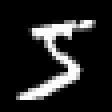
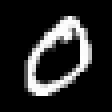
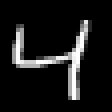
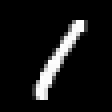
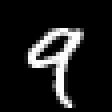

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [5]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

### Logistic classification (two classes - two predictors)

In [6]:
# convert images to vectors
trainX = batchImage2Vector(trainX)
size(trainX)

(42001,)

In [7]:
# select classes for prediction
c = (1, 5)

# data selection from above classes and sizes
trainX = vcat( trainX[trainY .== c[1] ], trainX[ trainY .== c[2] ] )
trainY = vcat( trainY[trainY .== c[1] ], trainY[ trainY .== c[2] ] )
display(levels(trainY))
size(trainX), size(trainY)

2-element Vector{Int64}:
 1
 5

((8514,), (8514,))

In [8]:
# generate predictors and outcome
function generatePredictors(X)
    N = size(X)[1]
    x1 = [meanIntensity(X[i]) for i in 1:N]
    x2 = [hSymmetry(X[i])     for i in 1:N]
    Xs = hcat(x1, x2)
    Xs = rescaleByColumns(Xs)
    
    return Xs
end

trainXLog = generatePredictors(trainX)
trainYLog = copy(trainY);


In [9]:
# specific conversions for MLJ
trainXLog = DataFrame(trainXLog, :auto)
trainYLog = categorical(trainYLog, ordered=true);


In [10]:
?MLJ.machine

```
machine(model, args...; cache=true)
```

Construct a `Machine` object binding a `model`, storing hyper-parameters of some machine learning algorithm, to some data, `args`. Calling `fit!` on a `Machine` object stores in the machine object the outcomes of applying the algorithm. This in turn enables generalization to new data using operations such as `predict` or `transform`:

```julia
using MLJModels
X, y = make_regression()

PCA = @load PCA pkg=MultivariateStats
model = PCA()
mach = machine(model, X)
fit!(mach, rows=1:50)
transform(mach, selectrows(X, 51:100)) # or transform(mach, rows=51:100)

DecisionTreeRegressor = @load DecisionTreeRegressor pkg=DecisionTree
model = DecisionTreeRegressor()
mach = machine(model, X, y)
fit!(mach, rows=1:50)
predict(mach, selectrows(X, 51:100)) # or predict(mach, rows=51:100)
```

Specify `cache=false` to prioritize memory management over speed, and to guarantee data anonymity when serializing composite models.

When building a learning network, `Node` objects can be substituted for the concrete data.

### Learning network machines

```
machine(Xs; oper1=node1, oper2=node2, ...)
machine(Xs, ys; oper1=node1, oper2=node2, ...)
machine(Xs, ys, extras...; oper1=node1, oper2=node2, ...)
```

Construct a special machine called a *learning network machine*, that wraps a learning network, usually in preparation to export the network as a stand-alone composite model type. The keyword arguments declare what nodes are called when operations, such as `predict` and `transform`, are called on the machine. An advanced option allows one to additionally pass the output of any node to the machine's report; see below.

In addition to the operations named in the constructor, the methods `fit!`, `report`, and `fitted_params` can be applied as usual to the machine constructed.

```
machine(Probabilistic(), args...; kwargs...)
machine(Deterministic(), args...; kwargs...)
machine(Unsupervised(), args...; kwargs...)
machine(Static(), args...; kwargs...)
```

Same as above, but specifying explicitly the kind of model the learning network is to meant to represent.

Learning network machines are not to be confused with an ordinary machine that happens to be bound to a stand-alone composite model (i.e., an *exported* learning network).

### Examples of learning network machines

Supposing a supervised learning network's final predictions are obtained by calling a node `yhat`, then the code

```julia
mach = machine(Deterministic(), Xs, ys; predict=yhat)
fit!(mach; rows=train)
predictions = predict(mach, Xnew) # `Xnew` concrete data
```

is  equivalent to

```julia
fit!(yhat, rows=train)
predictions = yhat(Xnew)
```

Here `Xs` and `ys` are the source nodes receiving, respectively, the input and target data.

In a unsupervised learning network for clustering, with single source node `Xs` for inputs, and in which the node `Xout` delivers the output of dimension reduction, and `yhat` the class labels, one can write

```julia
mach = machine(Unsupervised(), Xs; transform=Xout, predict=yhat)
fit!(mach)
transformed = transform(mach, Xnew) # `Xnew` concrete data
predictions = predict(mach, Xnew)
```

which is equivalent to

```julia
fit!(Xout)
fit!(yhat)
transformed = Xout(Xnew)
predictions = yhat(Xnew)
```

### Including a node's output in the report

The return value of a node called with no arguments can be included in a learning network machine's report, and so in the report of any composite model type constructed by exporting a learning network. This is useful for exposing byproducts of network training that are not readily deduced from the `report`s and `fitted_params` of the component machines (which are automatically exposed).

The following example shows how to expose `err1()` and `err2()`, where `err1` are `err2` are nodes in the network delivering training errors.

```julia
X, y = make_moons()
Xs = source(X)
ys = source(y)

model = ConstantClassifier()
mach = machine(model, Xs, ys)
yhat = predict(mach, Xs)
err1 = @node auc(yhat, ys)
err2 = @node accuracy(yhat, ys)

network_mach = machine(Probabilistic(),
                       Xs,
                       ys,
                       predict=yhat,
                       report=(auc=err1, accuracy=err2))

fit!(network_mach)
r = report(network_mach)
@assert r.auc == auc(yhat(), ys())
@assert r.accuracy == accuracy(yhat(), ys())
```


In [11]:
# fit the model
mdl = LogisticClassifier()
mach = machine(mdl, trainXLog, trainYLog)
fit!(mach)


┌ Info: Training Machine{LogisticClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464


Machine{LogisticClassifier,…} trained 1 time; caches data
  model: LogisticClassifier
  args: 
    1:	Source @092 ⏎ `Table{AbstractVector{ScientificTypesBase.Continuous}}`
    2:	Source @020 ⏎ `AbstractVector{OrderedFactor{2}}`


In [12]:
# predict with trainset
params = fitted_params(mach)
p = MLJ.predict(mach, trainXLog)
p[1:5]

5-element CategoricalDistributions.UnivariateFiniteArray{OrderedFactor{2}, Int64, UInt32, Float64, 1}:
 UnivariateFinite{OrderedFactor{2}}(1=>0.633, 5=>0.367)
 UnivariateFinite{OrderedFactor{2}}(1=>0.704, 5=>0.296)
 UnivariateFinite{OrderedFactor{2}}(1=>0.698, 5=>0.302)
 UnivariateFinite{OrderedFactor{2}}(1=>0.632, 5=>0.368)
 UnivariateFinite{OrderedFactor{2}}(1=>0.647, 5=>0.353)

In [13]:
p[1]

         UnivariateFinite{OrderedFactor{2}}     
     ┌                                        ┐ 
   1 ┤■■■■■■■■■■■■■■■■■■■■ 0.6330328095306961   
   5 ┤■■■■■■■■■■■■ 0.36696719046930387          
     └                                        ┘ 

In [14]:
# convert probability to classes
ŷ = predict_mode(mach, trainXLog)
ŷ[1:5]

5-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1
 1
 1
 1
 1

In [15]:
# metrics
confmat(ŷ, trainYLog)

              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      1      │      5      │
├─────────────┼─────────────┼─────────────┤
│      1      │    4651     │    1281     │
├─────────────┼─────────────┼─────────────┤
│      5      │     68      │    2514     │
└─────────────┴─────────────┴─────────────┘


,,,,,,,

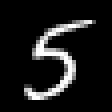
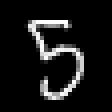
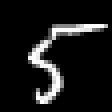
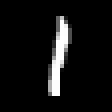
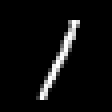
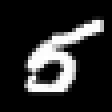
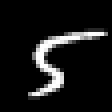
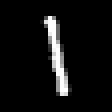

8-element Vector{Int64}:
 5
 5
 5
 1
 1
 5
 5
 1

8-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 1
 1
 1
 1
 1
 5
 1
 1

In [16]:
# demonstration of prediction accuracy
N = size(trainX)[1]
v = rand(1:N, 8)                            # select a random sample of images

trainXLog = generatePredictors(trainX[v])   # convert images to predictors
p = MLJ.predict(mach, trainXLog)            # predict outcome from sample images
ŷ = predict_mode(mach, trainXLog)           # convert probability to classes

display([MNIST.convert2image(vector2Image( trainX[i], 28, 28) ) for i in v])
display(trainY[v])
display(ŷ)